In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import itertools
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import autocorrelation_plot
from kneed import KneeLocator

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold

# **2 Methods**

### 2.1 Data Pre-Processing 

In [2]:
data_path = '/Users/maggie/Documents/Github/LogisticRegression_HPDmobile/H1_RS4_prob.csv'

start_date = '2019-11-26 00:00:00'
end_date = '2019-12-26 00:00:00'

In [3]:
#Import data
df = pd.read_csv(data_path, parse_dates = ["timestamp"])

#df1 is created seperately for the lag values, used in later sections. 
df1 = df.copy()
df1 = df1.fillna(0)

# Create 5 min averages.
df1.set_index("timestamp", inplace=True)
df1.index = pd.to_datetime(df1.index)
df1 = df1.resample(rule = '5min').mean()

#Occupied round 1 or 0. 
df1["occupied"] = df1["occupied"].apply(lambda x: 1 if (x >= 0.5) else 0)

#30 day interval: 2019-11-26 through 2019-12-25
df = (df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)])

#Determine the distribution of NaN values. 
count_nan_df = len(df) - df.count()
print('df', count_nan_df)

#forward fill NaN values - when investigating data. 
#df = df.fillna(method = "ffill")
#fill NaN with 0
df = df.fillna(0)

# Create 5 min averages.
df.set_index("timestamp", inplace=True)
df.index = pd.to_datetime(df.index)
df_avg = df.resample(rule = '5min').mean()

#round occupied/unoccupied
df_avg["occupied"] = df_avg["occupied"].apply(lambda x: 1 if (x >= 0.5) else 0)

#view first 5 rows of data. 
df_avg.tail()

df timestamp         0
hub               0
audio         11002
co2eq             0
light             0
rh                0
temp              0
img          126369
occupied       1355
dtype: int64


,audio,co2eq,light,rh,temp,img,occupied
timestamp,,,,,,,
2019-12-25 23:35:00,0.017800,0.806206,0.883883,1.000000,0.810217,0.0,0
2019-12-25 23:40:00,0.018271,0.806206,0.883883,0.987051,0.810217,0.0,0
2019-12-25 23:45:00,0.009635,0.806206,0.883883,0.971828,0.810217,0.0,0
2019-12-25 23:50:00,0.034479,0.806206,0.883883,0.974527,0.810217,0.0,0
2019-12-25 23:55:00,0.028034,0.806206,0.883883,0.987476,0.810217,0.0,0


#### 2.2.1 Offsetting Data
Based on explorations below

In [4]:
#keep last 8 hours from 11-25
df_1 = (df1.occupied[(df1.index >= '2019-11-25 16:00:00') & (df1.index < '2019-12-26 00:00:00')])

#convert to series
OA = pd.Series(df_1)

# 96 equal 8 hours for lag // add to dataframe
df_avg["lag8_occupied"] = OA.shift(periods=96)
df_avg["lag7_occupied"] = OA.shift(periods=84)
df_avg["lag6_occupied"] = OA.shift(periods=72)
df_avg["lag5_occupied"] = OA.shift(periods=60)
df_avg["lag4_occupied"] = OA.shift(periods=48)
df_avg["lag3_occupied"] = OA.shift(periods=36)
df_avg["lag2_occupied"] = OA.shift(periods=24)
df_avg["lag1_occupied"] = OA.shift(periods=12)

### 2.2 Time Series 

(-0.3, 0.3)

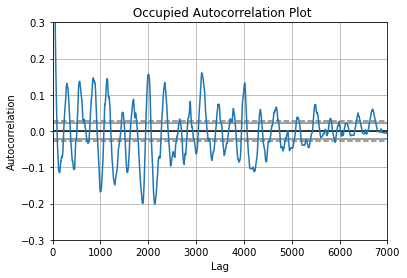

In [5]:
autocorrelation_plot(df_avg.occupied)
plt.title(' Occupied Autocorrelation Plot')
plt.xlim([0, 7000])
plt.ylim([-0.30,0.30])

# Note: Change the x-axis to shows hours, not 5-minute lags

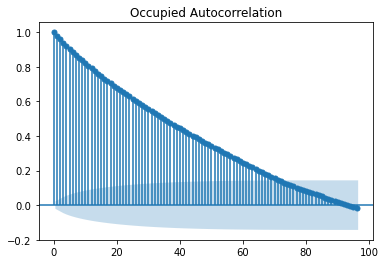

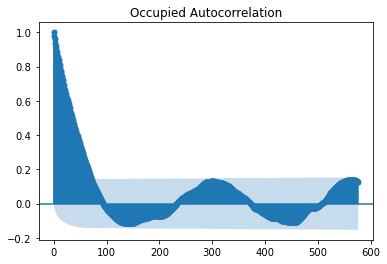

In [6]:
# 8 and 48 hours / figures 3 and 4. 
lags = [96, 576]

#alpha = 0.5 for 95% conf..
for l in lags:
    titles = "occupied"+ str(l)
    (smt.graphics.plot_acf(df_avg["occupied"],lags=l,alpha=0.05,title="Occupied Autocorrelation"))

### 2.3 Data Exploration

1    7049
0    1591
Name: occupied, dtype: int64


Text(0.5, 1.0, 'Occupancy Distribution')

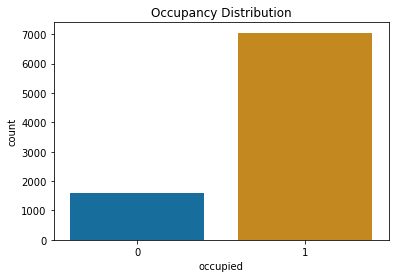

In [7]:
print(df_avg['occupied'].value_counts())
sns.countplot(x='occupied', data = df_avg, palette = 'colorblind').set_title('Occupancy Distribution')

In [8]:
#create a kmeans function
def km(x, mod_title):
    kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 1,
    "max_iter": 300,
    "random_state": 0,
   }
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(x)
        sse.append(kmeans.inertia_)

    #Elbow method
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.title(f"Best K: Elbow Method - {mod_title}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    
    #Pick best k
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    
    kmeans = KMeans(
    init="k-means++",
    n_clusters=kl.elbow,
    n_init=10,
    max_iter=300,
    random_state=0)
    
    labels = kmeans.fit_predict(x)
    u_labels = np.unique(labels)
 
    #plotting the results:
 
    for i in u_labels:
        plt.scatter(x[labels == i , 0] , x[labels == i , 1] , label = i, s=20)
    plt.title(f"K-Means Cluster - {mod_title}")
    plt.legend()
    plt.show()
    
    print(f'Best K: {kl.elbow}')
    
#     return{"Best K:":kl.elbow} 
# Did you actually mean to return this, or just print it?


In [16]:
x = 'jasmine'
print('hello', x)

print(f'hello {len(x)}!!! ')

hello jasmine
hello 7!!! 


In [31]:
# Audio + temperature
df_v= df_avg.iloc[:,[0, 4]]
Audio_Temperature = df_v.to_numpy()

# Audio + images
Audio_Images = df_avg[['audio', 'img']].to_numpy()

# Environmental
Environmental = df_avg.iloc[:, 1:5].to_numpy()

# Audio + images + environmental
all_mod = df_avg.iloc[:, 0:6].to_numpy()

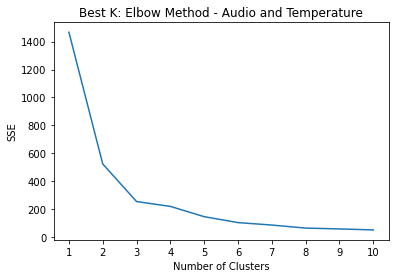

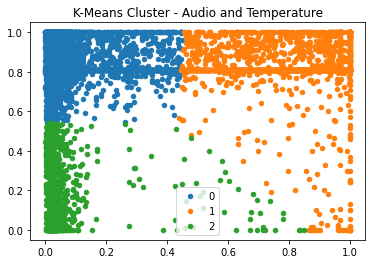

Best K: 3


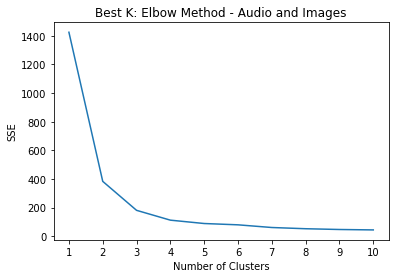

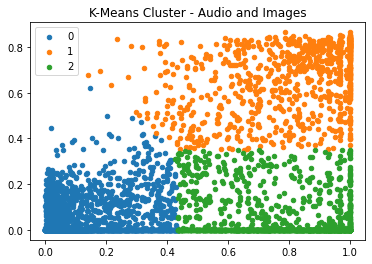

Best K: 3


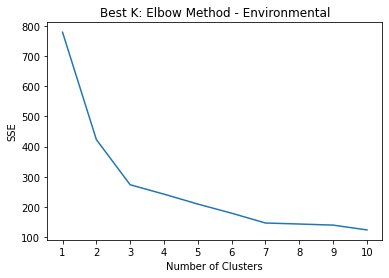

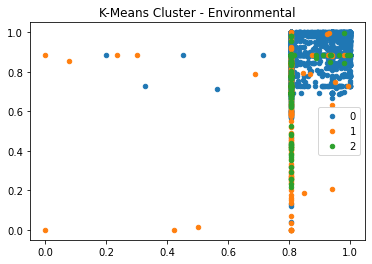

Best K: 3


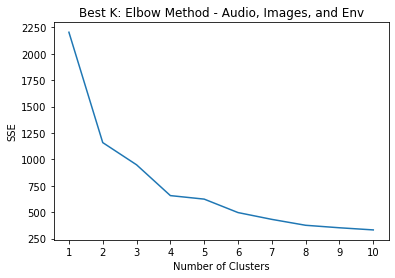

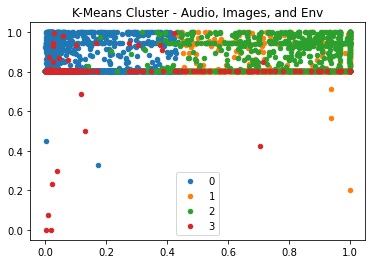

Best K: 4


In [32]:
km(Audio_Temperature, 'Audio and Temperature')
km(Audio_Images, 'Audio and Images')
km(Environmental, 'Environmental')
km(all_mod, 'Audio, Images, and Env')

In [17]:
def plot_corr_matrix(f, df, title):
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=8, rotation=10)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    plt.title('Mid-Day Correlation Matrix', fontsize=16)

                        audio     co2eq     light        rh      temp  \
timestamp                                                               
2019-11-26 06:00:00  0.700000  0.806206  0.883883  0.711526  0.810217   
2019-11-26 06:05:00  0.711547  0.806206  0.883883  0.978333  0.810217   
2019-11-26 06:10:00  0.503830  0.806206  0.883883  1.000000  0.810217   
2019-11-26 06:15:00  1.000000  0.806206  0.883883  0.753828  0.810217   
2019-11-26 06:20:00  0.776629  0.806206  0.891624  0.645368  0.810217   
...                       ...       ...       ...       ...       ...   
2019-11-29 10:00:00  0.892000  0.806206  0.883883  0.982822  0.834747   
2019-11-30 06:00:00  0.021540  0.806206  0.883883  0.947098  0.987348   
2019-11-30 06:05:00  0.041753  0.806206  0.883883  1.000000  0.822869   
2019-11-30 06:10:00  0.002489  0.806206  0.883883  0.979136  0.941893   
2019-11-30 06:15:00  0.091628  0.806206  0.883883  0.949329  0.920254   

                          img  occupied  lag8_occu

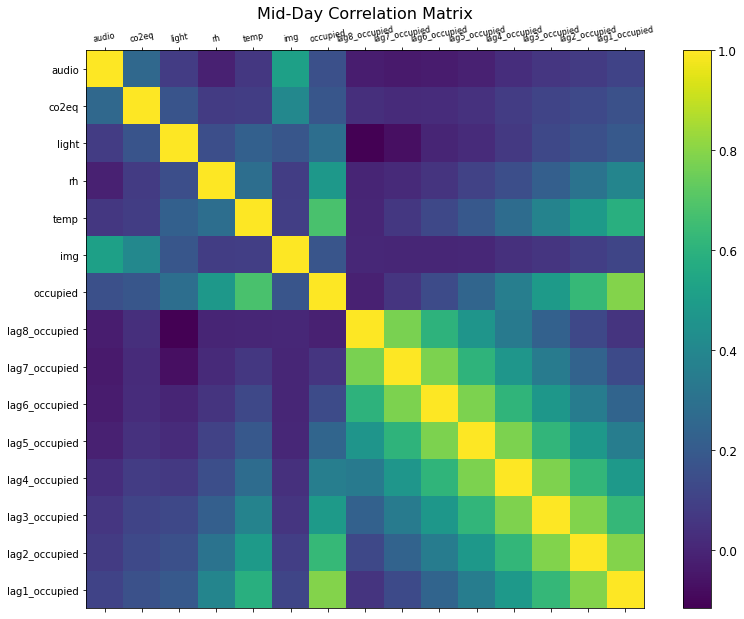

<Figure size 720x432 with 0 Axes>

In [19]:
f = plt.figure(figsize=(14, 10))
plot_corr_matrix(f=f, df=df_avg, title='30 Day Correlation Matrix')


df_avg_morning = df_avg.between_time('06:00','10:00')
f = plt.figure(figsize=(10, 6))
plot_corr_matrix(f=f, df=df_avg_morning, title='Morning Correlation Matrix')
# print(df_avg_morning.head(200))

df_avg_midday = df_avg.between_time('11:00','17:00')
f = plt.figure(figsize=(10, 6))
plot_corr_matrix(f=f, df=df_avg_midday, title='Midday Correlation Matrix')


df_avg_night = df_avg.between_time('18:00','22:00')
f = plt.figure(figsize=(10, 6))
plot_corr_matrix(f=f, df=df_avg_night, title='Night Correlation Matrix')


df_avg_midnight = df_avg.between_time('23:00','05:00')
f = plt.figure(figsize=(10, 6))
plot_corr_matrix(f=f, df=df_avg_midnight, title='Midnight Correlation Matrix')
